In [1]:
import os
import glob
import json
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

from A2D2Dataset import A2D2SegmentationDataset

import torch
from torch import autocast, amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

from collections import defaultdict
import pandas as pd

torch.backends.cudnn.benchmark = True


In [2]:
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_device()

device(type='cuda')

In [3]:
%%html
<!-- Potrzebne dla poprawnego wyświetlania tqdm w VSCode https://stackoverflow.com/a/77566731 -->
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [4]:
def generate_segmentation_mask(
        checkpoint_path, 
        input_img_path, 
        dataset,
        device = get_device(),
        model = None,
        model_arch = deeplabv3_resnet50,
        weights = DeepLabV3_ResNet50_Weights.DEFAULT,

    ):
    num_classes = len(dataset.class_names)

    if model == None:
        model = model_arch(weights=weights)
        model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
        model.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
        model = model.to(device=device)
    model.eval()

    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['model_state_dict'])
    epoch = ckpt['epoch']

    image = Image.open(input_img_path).convert("RGB")
    orig_width, orig_height = image.size

    transform = T.Compose([
        # T.Resize((768, 1280)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        prediction = output.argmax(1).squeeze(0).cpu().numpy()

    # Załadowywanie palety (mapa class_id -> RGB)
    class_id_to_color = {v: k for k, v in dataset.PALETTE.items()}

    # Kolorowy obraz predykcji
    color_pred = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
    for cls_id, rgb in class_id_to_color.items():
        color_pred[prediction == cls_id] = rgb

    # Wyjściowa interpolacja
    cp_t = torch.from_numpy(color_pred).permute(2, 0, 1).unsqueeze(0).float().to(device)
    cp_up = F.interpolate(cp_t,
                        size=(orig_height, orig_width),
                        mode='nearest')
    
    # z powrotem na numpy [H, W, 3]
    color_pred_interpolated = cp_up.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # zapis do pliku
    base, ext = os.path.splitext(input_img_path)
    new_path = base + "_pred7_ep" + str(epoch) + ext
    Image.fromarray(color_pred_interpolated).save(new_path)

In [5]:
import os
import json
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

def generate_segmentation_mask_tiled(
    checkpoint_path: str,
    input_img_path: str,
    output_path: str,
    list_json_path: str = ".\\data\\camera_lidar_semantic\\class_list.json",
    tile_size: tuple[int, int] = (768, 768),
    overlap: int = 128
) -> Image.Image:
    """
    Wczytuje model z checkpointu, dzieli dowolnej wielkości obraz na nakładające się kafle,
    uruchamia na każdym kaflu segmentację, skleja wynikową maskę w jedną pełno-rozmiarową
    kolorową mapę klas i zapisuje ją pod output_path. Zwraca wygenerowany PIL.Image.
    
    Args:
      checkpoint_path: ścieżka do .pth z kluczem 'model_state_dict'.
      input_img_path:  ścieżka do dowolnego obrazu RGB.
      output_path:     dokąd zapisać kolorową maskę.
      list_json_path:  ścieżka do pliku class_list.json (format: {"#HEX": "class_name", ...}).
      tile_size:       (wysokość, szerokość) pojedynczego kafla.
      overlap:         liczba pikseli nakładki w pionie i poziomie.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Używamy architektury DeepLabV3-ResNet50
    weights = DeepLabV3_ResNet50_Weights.DEFAULT
    model = deeplabv3_resnet50(weights=weights)

    # wczytywanie checkpointu
    ckpt = torch.load(checkpoint_path, map_location=device)
    state = ckpt.get("model_state_dict", ckpt)

    # Odczytaj liczbę klas z kształtu wagi ostatniej warstwy (classifier.4.weight)
    w_cls = state.get("classifier.4.weight", None)
    if w_cls is not None:
        num_classes = w_cls.shape[0]
    else:
        # Jeśli nie ma klasycznego klucza, weź liczbę z pretrenowanych meta-danych
        num_classes = len(weights.meta["categories"])

    # Nadpisz ostatnie warstwy, by pasowały do num_classes
    model.classifier[-1]    = torch.nn.Conv2d(256, num_classes, kernel_size=1)
    model.aux_classifier[-1] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

    model.load_state_dict(state)
    model.to(device).eval()

    #  odczytanie palety koloru
    with open(list_json_path, "r") as f:
        hex2name = json.load(f)


    id_to_rgb = {}
    for class_id, (hex_col, cls_name) in enumerate(hex2name.items()):
        r = int(hex_col[1:3], 16)
        g = int(hex_col[3:5], 16)
        b = int(hex_col[5:7], 16)
        id_to_rgb[class_id] = (r, g, b)

    # odczytanie obrazu wejściowego
    img_pil = Image.open(input_img_path).convert("RGB")
    orig_w, orig_h = img_pil.size
    tile_h, tile_w = tile_size

    # transformacje kafla
    tile_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    # pusta tablica wyniku
    result = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)

    # funkcja do obliczeń kaflowania
    def compute_tile_coords(img_w: int, img_h: int, tw: int, th: int, ov: int):
        xs, ys = [], []
        step_x = tw - ov
        step_y = th - ov

        x = 0
        while x + tw < img_w:
            xs.append(x)
            x += step_x
        xs.append(max(0, img_w - tw))

        y = 0
        while y + th < img_h:
            ys.append(y)
            y += step_y
        ys.append(max(0, img_h - th))

        return xs, ys

    xs, ys = compute_tile_coords(orig_w, orig_h, tile_w, tile_h, overlap)

    # iteracja po kaflach
    logits_accum = torch.zeros(num_classes, orig_h, orig_w, device="cpu")
    counts       = torch.zeros(orig_h, orig_w,               device="cpu")

    with torch.no_grad():
        for y in ys:
            for x in xs:
                box  = (x, y, x + tile_w, y + tile_h)
                tile = img_pil.crop(box)
                w_c, h_c = tile.size         # <--- brzegowy kafel?

                # PAD zamiast resize
                if (w_c != tile_w) or (h_c != tile_h):
                    pad_w = tile_w - w_c
                    pad_h = tile_h - h_c
                    tile  = T.functional.pad(tile, (0, 0, pad_w, pad_h),
                                            padding_mode="edge")

                inp   = tile_transform(tile).unsqueeze(0).to(device)
                out   = model(inp)["out"].cpu().squeeze(0)      # [C,H,W]

                # MEAN-blending logitów
                logits_accum[:, y:y+tile_h, x:x+tile_w] += out
                counts      [y:y+tile_h, x:x+tile_w]    += 1

    # argmax na zblendowanych logitach
    logits_accum /= counts.unsqueeze(0)
    pred_full     = logits_accum.argmax(0).numpy()    # [H,W]

    # kolorowanie
    result = np.zeros((orig_h, orig_w, 3), np.uint8)
    for cls_id, rgb in id_to_rgb.items():
        result[pred_full == cls_id] = rgb

    # konwersja na PIL i zapis
    result_img = Image.fromarray(result)
    result_img.save(output_path)
    return result_img

In [ ]:
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode

# transformacje geometryczne
transforms_geo = v2.Compose([ 
    v2.RandomResizedCrop((768, 768), scale=(0.5, 2.0), interpolation=InterpolationMode.NEAREST),
    v2.RandomHorizontalFlip(p=0.5),    
])

# transformacje obrazu (nie stosowane do maski)
transforms_img = v2.Compose([
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# wczytanie datasetu
dataset = A2D2SegmentationDataset(
    root_dir=".\\data\\camera_lidar_semantic\\",
    scenes=None,
    camera="cam_front_center",
    with_pointcloud=False,
    with_meta=False,
    transforms_geo=transforms_geo,
    transforms_img=transforms_img
)

# podział zbioru
g = torch.Generator().manual_seed(42)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size],
    generator=g
) 

# dataloadery
# parametry dobrane dla systemu z 12gb vram oraz 64gb ram
train_loader = DataLoader(
    train_dataset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=12, 
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True
    )

test_loader = DataLoader(
    test_dataset, 
    batch_size=4, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True,
    drop_last=True
    )

c:\Users\fhcar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].


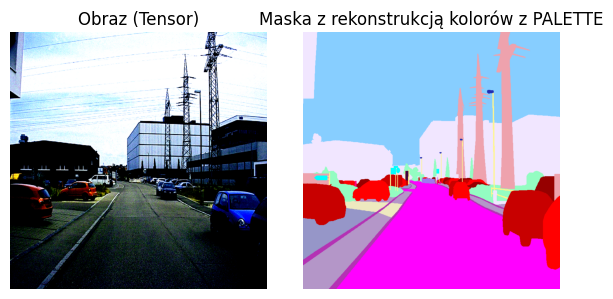

In [34]:
import matplotlib.pyplot as plt

item = dataset[10]
image = item['image']    # Tensor [C,H,W]
label = item['label']    # LongTensor [H,W] z indeksami klas

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# obraz (permutacja [C,H,W] → [H,W,C])
img_np = image.permute(1, 2, 0).cpu().numpy()
ax[0].imshow(img_np)
ax[0].set_title("Obraz (Tensor)")
ax[0].axis("off")

# kolorowanie maski
class_id_to_rgb = {v: k for k, v in dataset.PALETTE.items()}

lbl_np = label.cpu().numpy()    # [H, W] z wartościami od 0 do (num_classes-1)
H, W = lbl_np.shape
mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)

# łączenie maski
for cls_id, rgb in class_id_to_rgb.items():
    mask_rgb[lbl_np == cls_id] = rgb

ax[1].imshow(mask_rgb)
ax[1].set_title("Maska z rekonstrukcją kolorów z PALETTE")
ax[1].axis("off")

# wyświetlenie
plt.tight_layout()
plt.show()

In [8]:
# parametry wstępne
ckpt_name = "resnet50_test_2_new"
num_epochs = 30

# przygotowywanie plików
model_root_dir=".\\model\\"
ckpt_path = os.path.join(model_root_dir, ckpt_name + '.ckpt')
meta_path = os.path.join(model_root_dir, ckpt_name + '.csv')

device = get_device()

# przygotowanie historii / odczyt z pliku
history = pd.DataFrame(columns = ['epoch', 'train_loss', 'val_loss', 'mIoU'] + dataset.class_names)
history.index.name = "id"
if os.path.exists(meta_path):
    history = pd.read_csv(meta_path, index_col='id')

num_classes = len(dataset.class_names)

# przygotowanie modelu oraz warstw wejściowych / wyjściowych
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)
model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
model.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

model = model.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# wczytanie checkpointu
start_epoch = 0
if os.path.exists(ckpt_path):
    print(f"Loading checkpoint '{ckpt_name}'")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    start_epoch = ckpt['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")

# model = torch.compile(model)
scaler = amp.GradScaler()

# Pętla treningowa
for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        images = batch['image'].to(device, non_blocking=True)
        masks  = batch['label'].to(device, non_blocking=True)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}")

    # walidacja
    model.eval()
    running_val_loss = 0.0
    accum_inter = torch.zeros(num_classes, device=device)
    accum_union = torch.zeros(num_classes, device=device)

    conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.int64, device=device)

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['image'].to(device, non_blocking=True)
            masks  = batch['label'].to(device, non_blocking=True)

            with autocast(device_type='cuda'):
                outputs = model(images)['out']
                val_loss = criterion(outputs, masks)

            running_val_loss += val_loss.item() * images.size(0)

            preds = outputs.argmax(1)

            pred_flat = preds.view(-1)
            mask_flat = masks.view(-1)

            # Filtracja nieprawidłowych wartości
            valid = (mask_flat >= 0) & (mask_flat < num_classes)
            pred_flat = pred_flat[valid]
            mask_flat = mask_flat[valid]

            # Obliczanie macierzy pomyłek
            indices = num_classes * mask_flat + pred_flat
            conf_matrix += torch.bincount(indices, minlength=num_classes ** 2).reshape(num_classes, num_classes)

    # Obliczanie IoU
    val_loss_epoch = running_val_loss / len(test_loader.dataset)
    inter = torch.diag(conf_matrix).float()
    union = conf_matrix.sum(1) + conf_matrix.sum(0) - torch.diag(conf_matrix)
    ious = inter / (union + 1e-6)
    ious[union == 0] = float('nan')
    miou = torch.nanmean(ious).item()

    # Historia pomiarów
    ious_cpu = ious.detach().cpu().numpy() 
    row = {
        'epoch': float(epoch),
        'train_loss': float(epoch_loss),
        'val_loss':   float(val_loss_epoch),
        'mIoU':       float(miou)
    }

    for idx, cls_name in enumerate(dataset.class_names):
        val = ious_cpu[idx]
        row[cls_name] = float(val) if not (val != val) else float('nan')
    
    history.loc[len(history)] = row
    history.to_csv(meta_path)

    print(f"[Epoch {epoch+1}/{num_epochs}] Val   Loss: {val_loss_epoch:.4f} | mIoU: {miou:.4f}")
    for cls in range(num_classes):
        classs_name = dataset.class_names[cls] if cls < num_classes else f"Class {cls}"
        if torch.isnan(ious[cls]):
            print(f"  {classs_name:<30s} IoU: n/a")
        else:
            print(f"  {classs_name:<30s} IoU: {ious[cls]:.4f}")

    # Zapisanie / nadpisanie checkpointu
    if os.path.exists(ckpt_path):
        new_path = os.path.join(model_root_dir, ckpt_name + "_ep_" + str(epoch - 1) + '.ckpt')
        os.rename(ckpt_path, new_path)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    },  ckpt_path)

    scheduler.step()


Loading checkpoint 'resnet50_test_2_new'
Resuming from epoch 30


  0%|          | 0/5503 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Generowanie przykładowych obrazów
Po wytrenowaniu modelu należy wprowadzić poniżej nazwę checkpointu oraz ścieżkę do pliku `.png`, na  którym można przetestować działanie modelu.

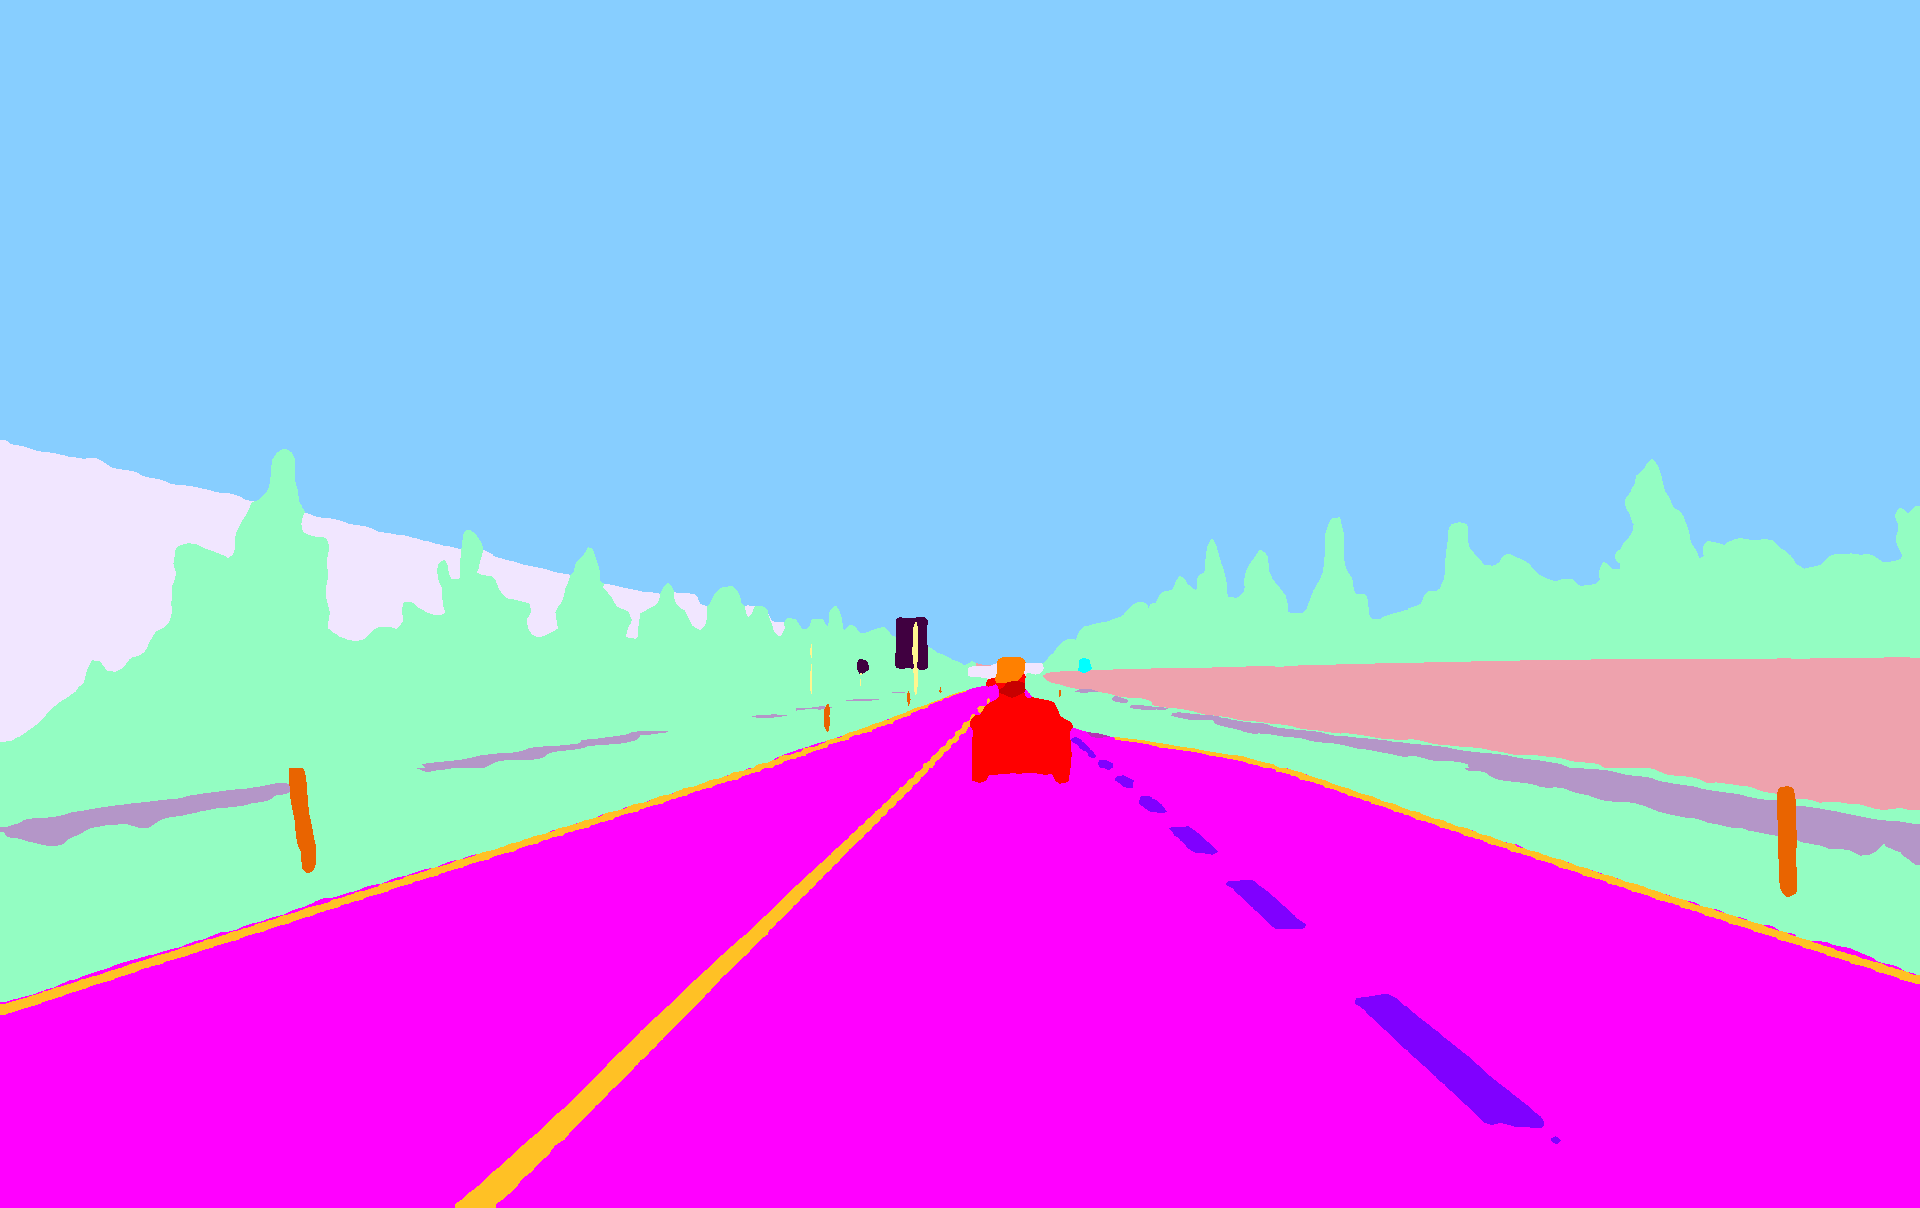

In [ ]:
generate_segmentation_mask_tiled(
    checkpoint_path=".\\model\\resnet50_test_2_new.ckpt",
    input_img_path=".\\test\\test3.png",
    tile_size=(768, 768),
    output_path=".\\test\\test3_new_lr1e-3_out_seg2.png",
    overlap=128
    )

In [ ]:
generate_segmentation_mask(
    checkpoint_path=".\\model\\resnet50_test_2_new.ckpt",
    input_img_path=".\\test\\test.png",
    dataset=dataset
)